In [2]:
import glob
import matplotlib.pyplot as plt
import onnxruntime as ort
import cv2 
import numpy as np


In [6]:
images_dir= '../DATA/raw-images'
test_images_fps= sorted(glob.glob(f'{images_dir}/*.jpg'))[:5]
print(len(test_images_fps))


images= []
# prepare_input
for i, img_path in enumerate(test_images_fps):
    img= cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    images.append(img.copy())
    
pre_images= np.array(images, dtype='float32').transpose(0, 3,1,2)/255.

5


In [17]:
orig_model_path="/home/adelb/Downloads/comp_200eps_abloss_model3b_3c_se_resnext50_32x4d_512.onnx"
softmax_model_path= "modified_model.onnx"
mask_model_path= "mask_model.onnx"

orig_session= ort.InferenceSession(orig_model_path, providers=['CPUExecutionProvider'])
softmax_session= ort.InferenceSession(softmax_model_path, providers=['CPUExecutionProvider'])
mask_session= ort.InferenceSession(mask_model_path, providers=['CPUExecutionProvider'])

ort_inputs = {"input": pre_images}


2025-03-21 15:52:29.806366398 [W:onnxruntime:, graph.cc:4285 CleanUnusedInitializersAndNodeArgs] Removing initializer 'norm'. It is not used by any node and should be removed from the model.
2025-03-21 15:52:30.258536355 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. 'segmentation_mask' source:{-1,-1,-1} target:{-1,18,-1,-1}. Falling back to lenient merge.


In [16]:
orig_outputs = orig_session.run(output_names=None, input_feed=ort_inputs)[0]
print(orig_outputs.shape)

def softmax(x, axis=1):
    """Applies softmax to a NumPy array along the specified axis."""
    x_exp = np.exp(x - np.max(x, axis=axis, keepdims=True))  # Subtract max for numerical stability
    return x_exp / np.sum(x_exp, axis=axis, keepdims=True)

orig_softmax_outputs= softmax(orig_outputs)
print(orig_softmax_outputs.shape)

orig_mask_outputs= orig_outputs.argmax(axis=1)
print(orig_mask_outputs.shape)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(float)) , expected: (tensor(uint8))

In [18]:
softmax_outputs = softmax_session.run(output_names=None, input_feed=ort_inputs)[0]
print(softmax_outputs.shape)

softmax_mask_output= softmax_outputs.argmax(axis=1)
print(softmax_mask_output.shape)

(5, 18, 1024, 1024)
(5, 1024, 1024)


In [29]:
print(np.allclose(softmax_outputs, orig_softmax_outputs, atol= 1e-4, rtol=1e-4))
print((softmax_mask_output == orig_mask_outputs).mean())

True
1.0


In [15]:
mask_outputs = mask_session.run(output_names=None, input_feed=ort_inputs)[0]
mask_outputs.shape

(5, 512, 512)

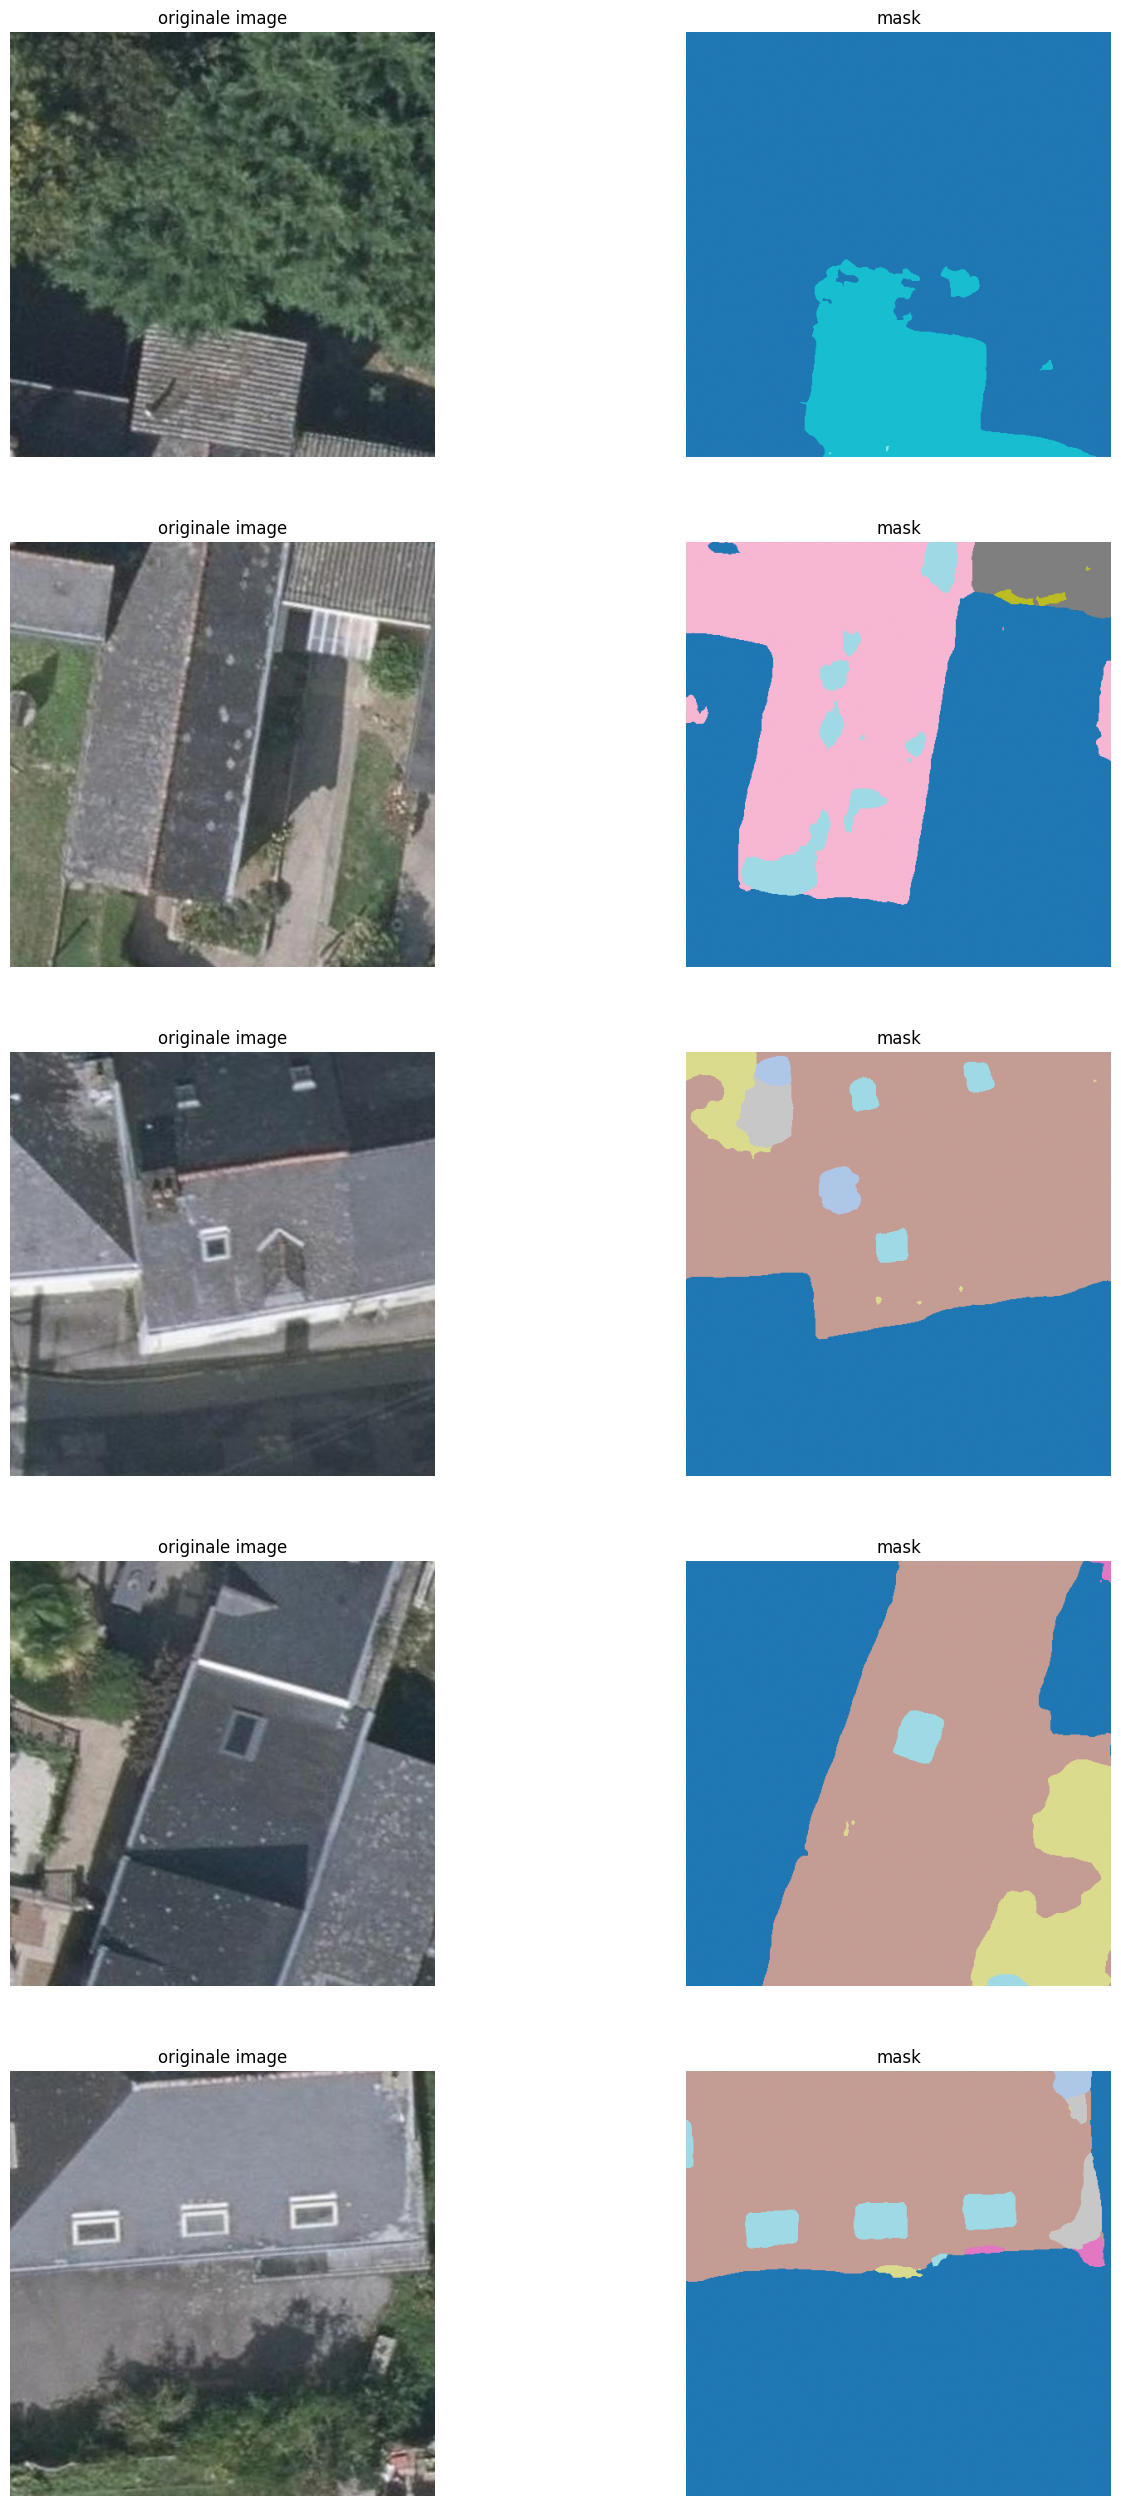

In [34]:
plt.figure(figsize= (16, 32))
for idx, img in enumerate(images):
    #original image
    plt.subplot(len(images), 2, idx*2 + 1)
    plt.imshow(img)
    plt.title("originale image")
    plt.axis('off')
    
    # orig_mask
    plt.subplot(len(images), 2, idx*2 + 2)
    plt.imshow(mask_outputs[idx], cmap='tab20')
    plt.title("mask")
    plt.axis("off")

plt.show()
    

In [14]:
import onnxruntime as ort
import numpy as np
import cv2

# --- Load the ONNX model ---
session = ort.InferenceSession("spot.onnx", providers=["CPUExecutionProvider"])
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
# --- Load and preprocess image ---
image = cv2.imread("/home/adelb/Pictures/qgis/nwe-spot-data/2015/images/13062025_112756/tile_img_0_0.png")  # BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if model expects RGB
# image = cv2.resize(image, (224, 224))           # Resize to model input size
input_data = image.astype(np.float32) / 255.0 
input_data = (input_data - mean) / std
input_data = np.transpose(input_data, (2, 0, 1))  # (H,W,C) -> (C,H,W) if model expects that
input_data = np.expand_dims(input_data, axis=0)   # Add batch dimension

# --- Run inference ---
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

outputs = session.run([output_name], {input_name: input_data})[0]

print("Model output:", outputs)


Model output: [[[[ 12.027879    14.270779    16.513678   ...  18.96886
     18.186897    17.404911  ]
   [ 13.589596    15.783007    17.976418   ...  21.25436
     20.254295    19.254204  ]
   [ 15.151312    17.295235    19.439161   ...  23.539858
     22.321695    21.103497  ]
   ...
   [ -6.454812    -4.945648    -3.4364834  ...   8.165737
      5.9823623    3.7989204 ]
   [ -1.6055388   -0.16989899   1.2657413  ...   8.280555
      6.691449     5.1022944 ]
   [  3.243883     4.605997     5.9681106  ...   8.395376
      7.4005575    6.405708  ]]

  [[-10.273984   -11.696623   -13.119262   ... -18.991924
    -17.254122   -15.516268  ]
   [-10.887182   -12.833118   -14.779056   ... -20.402378
    -18.531742   -16.661049  ]
   [-11.5003805  -13.969614   -16.438848   ... -21.812832
    -19.809362   -17.80583   ]
   ...
   [ 24.800476    24.057186    23.313894   ... -10.518164
     -6.363748    -2.2092047 ]
   [ 18.948277    17.8098      16.67132    ...  -9.750538
     -6.0658717   -2.381

In [15]:
# --- Apply softmax ---
def softmax(x, axis=1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

probs = softmax(outputs, axis=1)

# --- Get predicted class ---
pred_class = probs.argmax(axis=1)

print("Probabilities:", probs)
print("Predicted class index:", pred_class)

Probabilities: [[[[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
    1.0000000e+00 1.0000000e+00]
   [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
    1.0000000e+00 1.0000000e+00]
   [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
    1.0000000e+00 1.0000000e+00]
   ...
   [2.6668665e-14 2.5364663e-13 2.4124515e-12 ... 9.9999988e-01
    9.9999511e-01 9.9754471e-01]
   [1.1846530e-09 1.5542337e-08 2.0391168e-07 ... 9.9999988e-01
    9.9999702e-01 9.9943787e-01]
   [5.2638217e-05 9.5178181e-04 1.6949369e-02 ... 1.0000000e+00
    9.9999809e-01 9.9987137e-01]]

  [[2.0626430e-10 5.2783819e-12 1.3507606e-13 ... 3.2646797e-17
    4.0565964e-16 5.0409552e-15]
   [2.3435292e-11 3.7340039e-13 5.9494709e-15 ... 8.1041682e-19
    1.4303356e-17 2.5246659e-16]
   [2.6626706e-12 2.6414885e-14 2.6204650e-16 ... 2.0117606e-20
    5.0432918e-19 1.2644307e-17]
   ...
   [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 7.6857258e-09
    4.3466057e-06 2.4526562e-03]

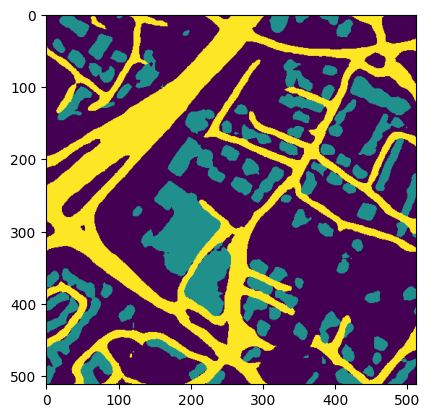

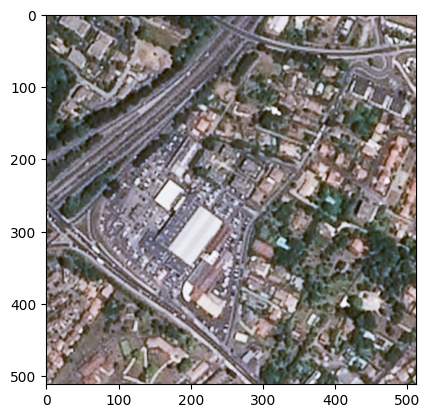

In [16]:
import matplotlib.pyplot as plt

plt.imshow(pred_class.squeeze()); plt.show()
plt.imshow(image); plt.show()

In [17]:
import onnx

model = onnx.load("spot.onnx")

# Access the first input tensor
input_tensor = model.graph.input[0]
input_shape = input_tensor.type.tensor_type.shape

# Force fixed height & width
input_shape.dim[2].dim_value = 512  # height
input_shape.dim[3].dim_value = 512  # width

# Save new model
onnx.save(model, "spot.onnx")
